In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

# Imported Libraries

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time

# isFraudifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections


# Other Libraries
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
warnings.filterwarnings("ignore")


df = pd.read_csv('Fraud.csv')
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [2]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [3]:
df.isnull().sum().max()

0

In [4]:
df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

In [5]:
# The classes are heavily skewed we need to solve this issue later.
print('No Frauds', round(df['isFraud'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['isFraud'].value_counts()[1]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['isFraud'].value_counts()[1]), ' of the dataset')

No Frauds 99.87 % of the dataset
Frauds 0.13 % of the dataset
Frauds 8213  of the dataset


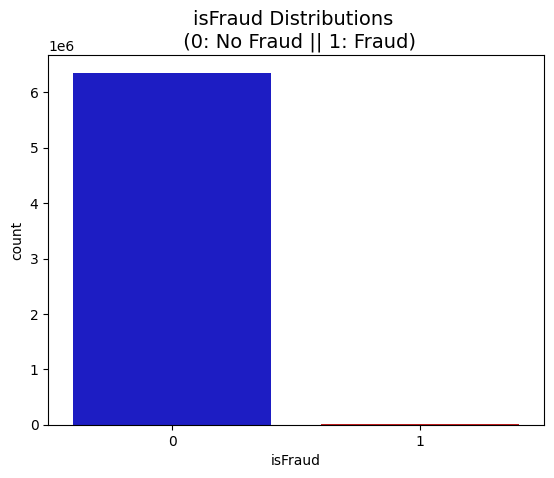

In [6]:
colors = ["#0101DF", "#DF0101"]

sns.countplot(x ='isFraud', data=df, palette=colors)
plt.title('isFraud Distributions \n (0: No Fraud || 1: Fraud)', fontsize=14)
plt.show()

In [7]:
from sklearn.preprocessing import LabelEncoder

# Label encoding
le = LabelEncoder()
df['type_encoded'] = le.fit_transform(df['type'])
df['nameOrig_encoded'] = le.fit_transform(df['nameOrig'])
df['nameDest_encoded'] = le.fit_transform(df['nameDest'])


# Display the transformed DataFrame
print(df.head())

   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  \
0  M1979787155             0.0             0.0        0               0   
1  M2044282225             0.0             0.0        0               0   
2   C553264065             0.0             0.0        1               0   
3    C38997010         21182.0             0.0        1               0   
4  M1230701703             0.0             0.0        0               0   

   type_encoded  nameOrig_encoded  nameDest_encoded  
0             3            757869           

In [8]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,type_encoded,nameOrig_encoded,nameDest_encoded
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,3,757869,1662094
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,3,2188998,1733924
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,4,1002156,439685
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,1,5828262,391696
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,3,3445981,828919


In [9]:
df = df.drop(['type', 'nameOrig', 'nameDest'], axis=1)

In [10]:
df.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,type_encoded,nameOrig_encoded,nameDest_encoded
0,1,9839.64,170136.0,160296.36,0.0,0.0,0,0,3,757869,1662094
1,1,1864.28,21249.0,19384.72,0.0,0.0,0,0,3,2188998,1733924
2,1,181.00,181.0,0.00,0.0,0.0,1,0,4,1002156,439685
3,1,181.00,181.0,0.00,21182.0,0.0,1,0,1,5828262,391696
4,1,11668.14,41554.0,29885.86,0.0,0.0,0,0,3,3445981,828919


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

print('No Frauds', round(df['isFraud'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['isFraud'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

X = df.drop('isFraud', axis=1)
y = df['isFraud']

sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in sss.split(X, y):
    print("Train:", train_index, "Test:", test_index)
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]

# We already have X_train and y_train for undersample data thats why I am using original to distinguish and to not overwrite these variables.
# original_Xtrain, original_Xtest, original_ytrain, original_ytest = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the Distribution of the labels


# Turn into an array
original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

# See if both the train and test label distribution are similarly distributed
train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)
print('-' * 100)

print('Label Distributions: \n')
print(train_counts_label/ len(original_ytrain))
print(test_counts_label/ len(original_ytest))

No Frauds 99.87 % of the dataset
Frauds 0.13 % of the dataset
Train: [1272422 1272423 1272424 ... 6362617 6362618 6362619] Test: [      0       1       2 ... 1510291 1510292 1510293]
Train: [      0       1       2 ... 6362617 6362618 6362619] Test: [1272422 1272423 1272424 ... 3958614 3958615 3958622]
Train: [      0       1       2 ... 6362617 6362618 6362619] Test: [2544062 2544063 2544064 ... 6009078 6009346 6009347]
Train: [      0       1       2 ... 6362617 6362618 6362619] Test: [3815834 3815835 3815836 ... 6243165 6243166 6243645]
Train: [      0       1       2 ... 6243165 6243166 6243645] Test: [5087485 5087486 5087487 ... 6362617 6362618 6362619]
----------------------------------------------------------------------------------------------------
Label Distributions: 

[0.99870926 0.00129074]
[0.99870887 0.00129113]


In [12]:
original_ytest

array([0, 0, 0, ..., 1, 1, 1], dtype=int64)

In [13]:
# Since our classes are highly skewed we should make them equivalent in order to have a normal distribution of the classes.

# Lets shuffle the data before creating the subsamples

df = df.sample(frac=1)

# amount of fraud classes 8213 rows.
fraud_df = df.loc[df['isFraud'] == 1]
non_fraud_df = df.loc[df['isFraud'] == 0][:8213]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,type_encoded,nameOrig_encoded,nameDest_encoded
3863293,283,217111.00,10496.00,0.00,1016770.07,1233881.06,0,0,1,3535277,242960
1591495,156,477017.32,12241.00,489258.32,257796.78,0.00,0,0,0,105961,422057
6002113,428,3037.67,3037.67,0.00,800854.71,803892.38,1,0,1,2754742,425624
5407592,378,192815.77,192815.77,0.00,0.00,192815.77,1,0,1,1895760,380955
6286331,660,6749.18,6749.18,0.00,136928.04,143677.22,1,0,1,5873174,72368


Distribution of the Classes in the subsample dataset
isFraud
0    0.5
1    0.5
Name: count, dtype: float64


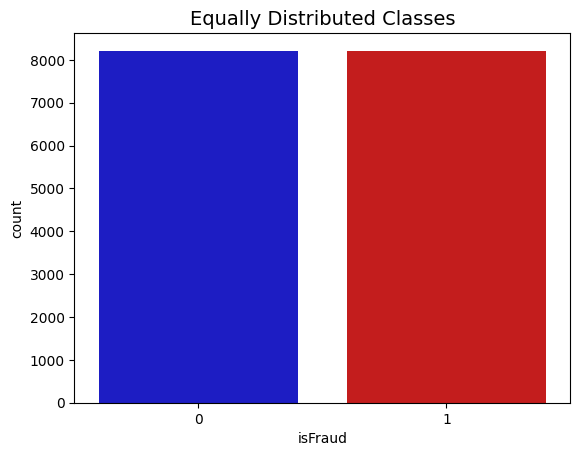

In [14]:
print('Distribution of the Classes in the subsample dataset')
print(new_df['isFraud'].value_counts()/len(new_df))



sns.countplot(x='isFraud', data=new_df, palette=colors)
plt.title('Equally Distributed Classes', fontsize=14)
plt.show()

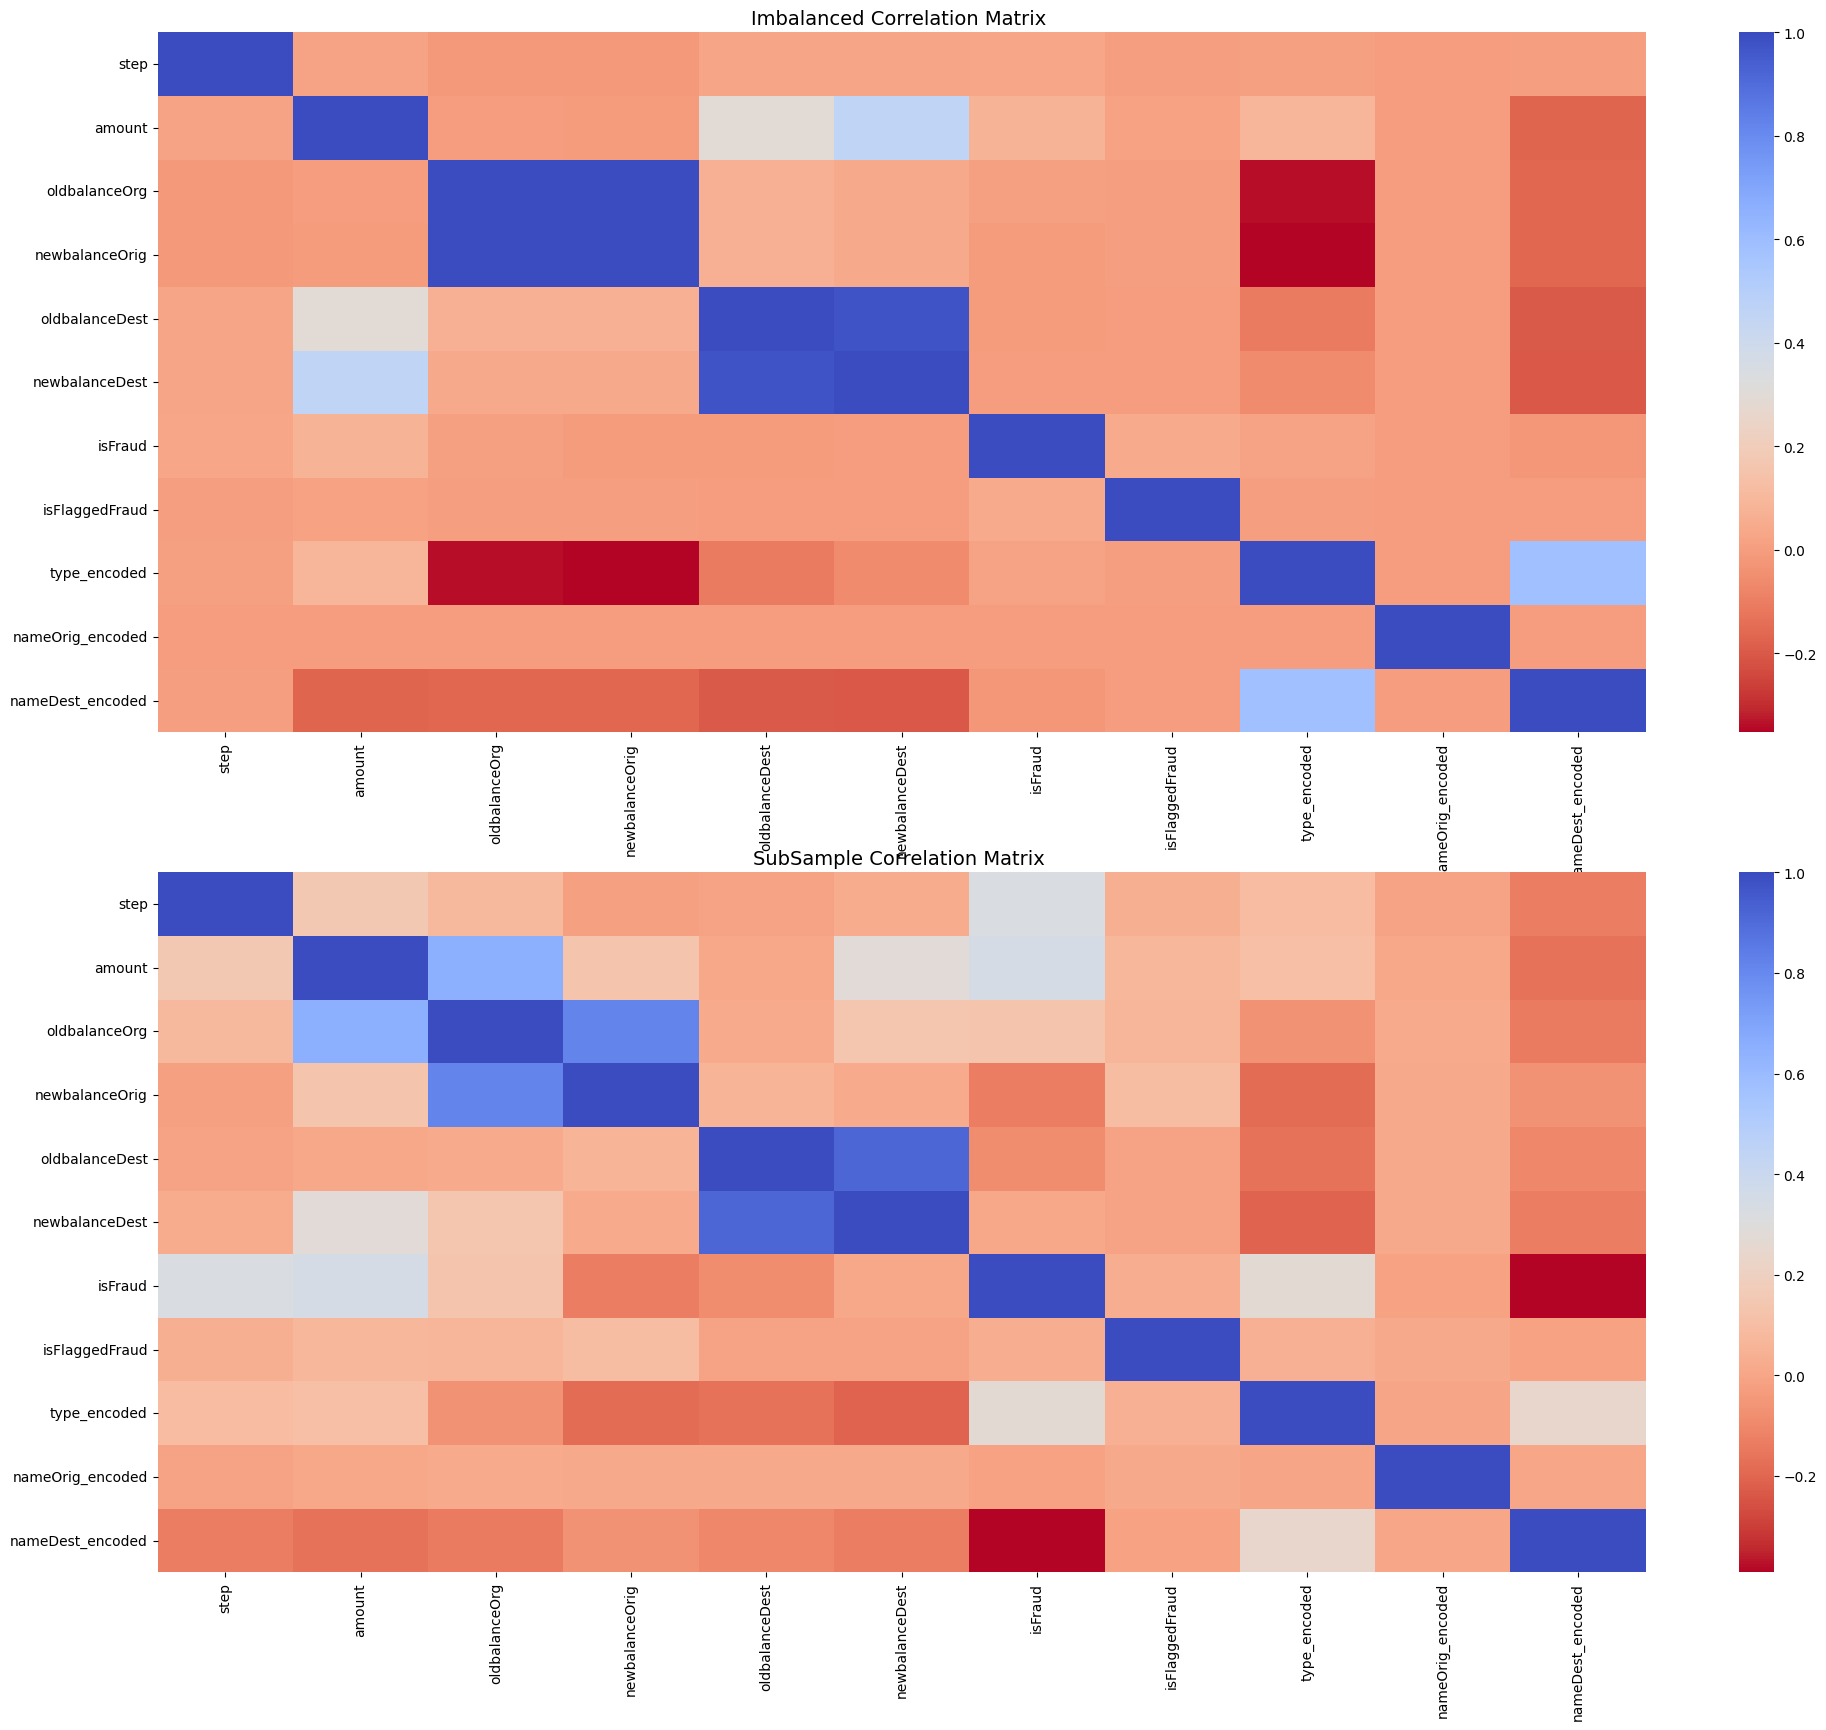

In [15]:
# Make sure we use the subsample in our correlation

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(24,20))

# Entire DataFrame
corr = df.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax1)
ax1.set_title("Imbalanced Correlation Matrix ", fontsize=14)


sub_sample_corr = new_df.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax2)
ax2.set_title('SubSample Correlation Matrix ', fontsize=14)
plt.show()

In [16]:
# Undersampling before cross validating (prone to overfit)
X = new_df.drop('isFraud',axis=1)
y = new_df['isFraud']

In [17]:
# Our data is already scaled we should split our training and test sets
from sklearn.model_selection import train_test_split

# This is explicitly used for undersampling.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
# Turn the values into an array for feeding the classification algorithms.
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [19]:
# Let's implement simple classifiers
from xgboost import XGBClassifier
classifiers = {
    "LogisiticRegression": LogisticRegression(),
    "KNearest": KNeighborsClassifier(),
    "Support Vector Classifier": SVC(),
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "XGBClassifier": XGBClassifier()
}

In [20]:
# Wow our scores are getting even high scores even when applying cross validation.
from sklearn.model_selection import cross_val_score


for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    training_score = cross_val_score(classifier, X_train, y_train, cv=5)
    print("Classifiers: ", classifier.__class__.__name__, "Has a training score of", round(training_score.mean(), 2) * 100, "% accuracy score")

Classifiers:  LogisticRegression Has a training score of 94.0 % accuracy score
Classifiers:  KNeighborsClassifier Has a training score of 90.0 % accuracy score
Classifiers:  SVC Has a training score of 89.0 % accuracy score
Classifiers:  DecisionTreeClassifier Has a training score of 99.0 % accuracy score
Classifiers:  XGBClassifier Has a training score of 99.0 % accuracy score


In [21]:
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score


for key, classifier in classifiers.items():
    # Train the classifier
    classifier.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = classifier.predict(X_test)
    
    # Print the classification report (which includes precision, recall, and F1-score)
    print(f"Classifier: {classifier.__class__.__name__}")
    print(classification_report(y_test, y_pred))
    
    # calculate precision, recall, and F1-score
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print("-" * 60)


Classifier: LogisticRegression
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      1622
           1       0.95      0.93      0.94      1664

    accuracy                           0.94      3286
   macro avg       0.94      0.94      0.94      3286
weighted avg       0.94      0.94      0.94      3286

Precision: 0.94
Recall: 0.94
F1 Score: 0.94
------------------------------------------------------------
Classifier: KNeighborsClassifier
              precision    recall  f1-score   support

           0       0.89      0.90      0.90      1622
           1       0.90      0.89      0.90      1664

    accuracy                           0.90      3286
   macro avg       0.90      0.90      0.90      3286
weighted avg       0.90      0.90      0.90      3286

Precision: 0.90
Recall: 0.90
F1 Score: 0.90
------------------------------------------------------------
Classifier: SVC
              precision    recall  f1-score   support

 